# Taxi Trips and Traffic

Where most models use real-time data from users to predict arrival
times at any given moment, we believe they could be improved by including a predictive
element. Our intent is to use the NYC Taxi and Limousine Commission's yellow and green cab data set to estimate density of pickup and dropoffs at any given place and time. We will then use the density as a proxy for traffic to estimate the time it takes to arrive at a destination.

In [1]:
%matplotlib inline
import edward as ed
from edward.models import Normal
import pandas as pd
pd.set_option('float_format', '{:f}'.format)
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from setup import set_random_seeds
import data
import preprocessing.preprocessing
set_random_seeds(42)
plt.style.use("seaborn-talk")
sns.set_context("talk")

## Data

We used the
[2015 NYC Yellow Cab Dataset](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml),
which consists of pickup and dropoff coordinates for trips, along 
with metadata like cost, distance, and number of passengers.

In [ ]:
def get_manhattan_data(path):
    full_dataset = preprocessing.preprocessing.get_data(path)
    manhattan_pickups = full_dataset.where(full_dataset["pickup_boro"] == "Manhattan")
    return manhattan_pickups.where(manhattan_pickups["dropoff_boro"] == "Manhattan").dropna()
    
manhattan = get_manhattan_data("data/preprocessed.csv")

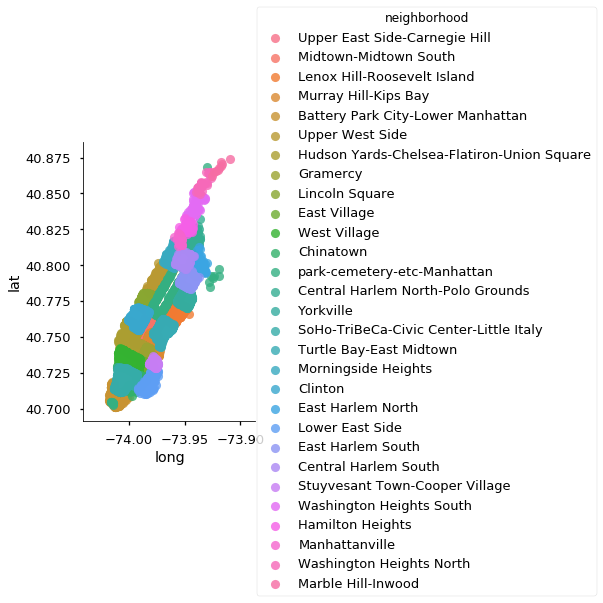

In [3]:
def visualize(dataset):
    dat = np.concatenate((dataset.loc[:, ['pickup_longitude', 'pickup_latitude']].as_matrix(),
                          dataset.loc[:, ['dropoff_longitude', 'dropoff_latitude']].as_matrix()))
    sns.regplot(dat[:, 0], dat[:, 1])
    plt.show()

def visualize_by_boro(dataset):
    pickups = dataset.loc[:, ["pickup_longitude", "pickup_latitude", "pickup_neighborhood_name"]]
    pickups.columns = ["long", "lat", "neighborhood"]
    dropoffs = dataset.loc[:, ["dropoff_longitude", "dropoff_latitude", "dropoff_neighborhood_name"]]
    dropoffs.columns = ["long", "lat", "neighborhood"]
    data = pd.concat((pickups, dropoffs)).dropna()
    sns.lmplot(x="long", y="lat", hue="neighborhood", data=data, fit_reg=False)
    plt.show()

indices = np.random.choice(manhattan.shape[0], size=10000, replace=False)

visualize_by_boro(manhattan.iloc[indices, :])

## Model

We will begin by trying to model the trip duration between two neighborhoods. Specifically, Morningside Heights and Upper East Side-Carnegie Hill

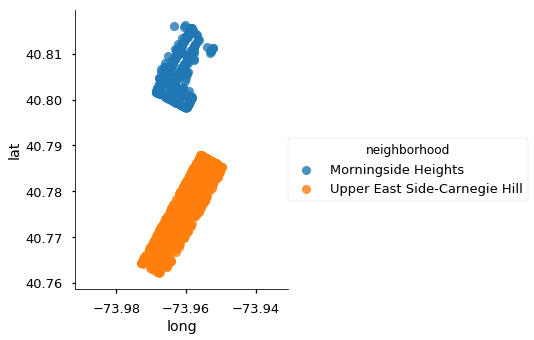

In [4]:
def get_neighborhood_to_neighborhood(source_neighborhood, sink_neighborhood, full_dataset):
    x = full_dataset.where((full_dataset["pickup_neighborhood_name"] == source_neighborhood) &
                           (full_dataset["dropoff_neighborhood_name"] == sink_neighborhood)).dropna()
    return x
    
def add_arrival_timestamp(x):
    x["dropoff_timestamp"] = x["pickup_timestamp"] + x["trip_duration"]
    return x

def add_dropoff_datetime(x):
    # This takes a while...
    x["dropoff_datetime"] = x["pickup_datetime"] + x["trip_duration"].apply(lambda x: pd.Timedelta(seconds=x))
    return x

def add_dropoff_hour(x):
    if "dropoff_datetime" not in x.columns:
        x = add_dropoff_datetime(x)
    x["dropoff_hour"] = x["dropoff_datetime"].apply(lambda x: x.hour)
    return x
    
def add_pickup_hour(x):
    x["pickup_hour"] = x["pickup_datetime"].apply(lambda x: x.hour)
    return x

manhattan = add_arrival_timestamp(manhattan)
ues_to_msh = get_neighborhood_to_neighborhood("Morningside Heights", "Upper East Side-Carnegie Hill", manhattan)
ues_to_msh = add_dropoff_hour(ues_to_msh)
ues_to_msh = add_pickup_hour(ues_to_msh)
visualize_by_boro(ues_to_msh)

Lets graph the trip duration by hour of day

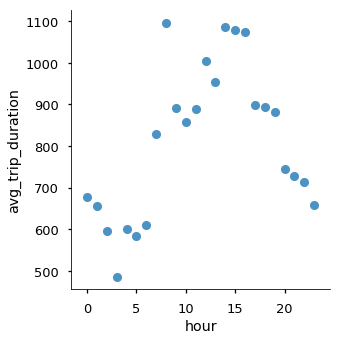

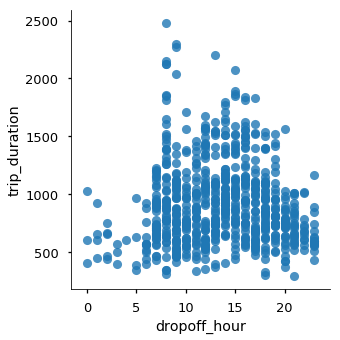

In [85]:
# note that the selection of the trip_duration column here is 
# arbitrary, the count would be the same regardless of column selected
avg_duration = ues_to_msh.groupby("dropoff_hour")["trip_duration"].mean().to_frame("avg_trip_duration")
avg_duration["hour"] = range(24)
sns.lmplot(x="hour", y="avg_trip_duration", data=avg_duration, fit_reg=False)
plt.show()
sns.lmplot(x="dropoff_hour", y="trip_duration", data=ues_to_msh, fit_reg=False)
plt.show()

Need to remove some outliers

In [6]:
def remove_outliers(data, col, frac_stddev):
    bound = frac_stddev * data.describe()[col]["std"]
    return data.where(np.abs(data[col]) < bound).dropna()
ues_to_msh = remove_outliers(ues_to_msh, "trip_duration", 1.0)

re-graph

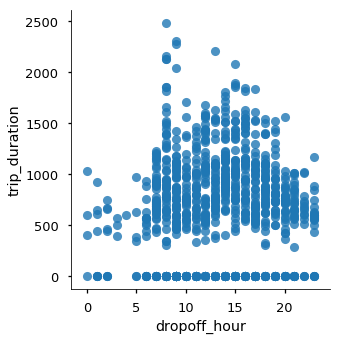

In [7]:
sns.lmplot(x="dropoff_hour", y="trip_duration", data=ues_to_msh, fit_reg=False)
plt.show()

For some reason, there are also a bunch of -1's. Maybe missing data?

In [8]:
def remove_leq_zero(data, col):
    return data.where(data[col] > 0).dropna()
ues_to_msh = remove_leq_zero(ues_to_msh, "trip_duration")

re-graph

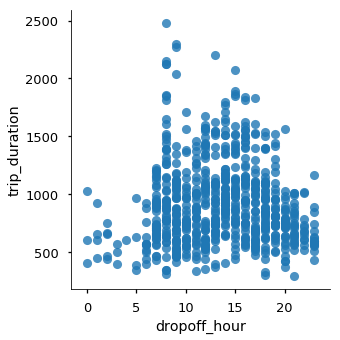

In [9]:
sns.lmplot(x="dropoff_hour", y="trip_duration", data=ues_to_msh, fit_reg=False)
plt.show()

Add manhattan distance to the dataset

In [39]:
def add_manhattan_distance(data):
    data["manhattan_distance"] = abs(data["pickup_longitude"] - data["dropoff_longitude"] + \
                                 data["pickup_latitude"] - data["dropoff_latitude"])
    return data
ues_to_msh = add_manhattan_distance(ues_to_msh)

Graph distance to trip duration

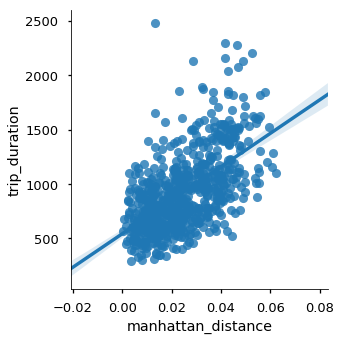

In [41]:
sns.lmplot(x="manhattan_distance", y="trip_duration", data=ues_to_msh, fit_reg=True)
plt.show()

Lets model this with a simple GLM

In [86]:
ues_to_msh = ues_to_msh.dropna()
x = ues_to_msh.drop(["Unnamed: 0","id", "vendor_id", "pickup_datetime",
                             "store_and_fwd_flag", "trip_duration",
                             "pickup_boro", "pickup_boro_code", "pickup_neighborhood_name",
                             "pickup_neighborhood_code", "dropoff_boro", "dropoff_boro_code",
                             "dropoff_neighborhood_name", "dropoff_neighborhood_code",
                             "dropoff_timestamp", "dropoff_datetime",
                             "dropoff_hour"], axis=1)
y = ues_to_msh["trip_duration"]

# the timestamp value was too large and causing divergence
x.loc[:, "pickup_timestamp"] = x["pickup_timestamp"] - x["pickup_timestamp"].mean()
x.reset_index(inplace=True, drop=True)
# note that y's indices need to be reset differently because it is actually a series rather than dataframe
y = y.reset_index(drop=True)

In [87]:
print(x.columns)

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'pickup_timestamp',
       'pickup_hour', 'manhattan_distance'],
      dtype='object')


In [138]:
train_indices = np.random.choice(x.shape[0], size=int(x.shape[0] * 0.1), replace=False)

x_train = x.iloc[train_indices, :]
train_ind_5pm = x_train.where(x["pickup_hour"] == 5).dropna()
print(train_ind_5pm)
return
x_train_5pm_pickup = x[train_ind_5pm]
y_train = y.iloc[train_indices]


x_test = x.drop(train_indices)
y_test = y.drop(train_indices)

# convert y to minutes instead of seconds
y_train = y_train / 60
y_test = y_test / 60

x_train = x_train.loc[:, ["manhattan_distance", "pickup_hour", "passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]
x_test = x_test.loc[:, ["manhattan_distance", "pickup_hour", "passenger_count", "pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]

N, D = x_train.shape
X = tf.placeholder(tf.float32, [None, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=[0.0], scale=1.0)
Y = Normal(loc=ed.dot(X, w) + b, scale=1.0)

qw = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D])),
                                       scale=tf.Variable(tf.random_normal([D])))

qb = ed.models.NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                                       scale=tf.Variable(tf.random_normal([1])))

inference = ed.KLqp({w: qw, b: qb}, data={X: x_train.as_matrix(), Y: y_train.as_matrix()})
inference.run(n_iter=10000)

10000/10000 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 1276.030


Check the MSE

In [139]:
y_post = Normal(loc=ed.dot(X, qw) + qb, scale=1.0)
# only manhattan distance =>  776342.81
# + pickup timestamp      => 7317449.0
# - pickup timestamp
# + pickup hour           =>  225920.56
# + passenger count       =>  222533.69
ed.evaluate("mean_absolute_error", data={X: x_test.as_matrix(),
                                        y_post: y_test.as_matrix()})


4.6442599

### Results of a Linear Model
On average we have an absolute error of about 4:30 for each trip